### Домашнее задание 1

#### 1

Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания).


In [97]:
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import multivariate_normal

In [98]:
df = pd.read_csv("owid-covid-data.csv", parse_dates=["date"])

In [99]:
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [100]:
start_date = pd.to_datetime("2020-03-03")
df_ru = df[(df["location"] == "Russia") & (df["date"] >= start_date)]
df_ru["new_cases"] = df_ru["new_cases"].apply(lambda x: 1.0 if x == 0.0 else x)
df_ru["day_number"] = np.arange(1, df_ru.shape[0] + 1)

<ipython-input-100-9526609e1908>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ru["new_cases"] = df_ru["new_cases"].apply(lambda x: 1.0 if x == 0.0 else x)
<ipython-input-100-9526609e1908>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ru["day_number"] = np.arange(1, df_ru.shape[0] + 1)


In [101]:
train_size = 50
train = df_ru[:train_size]
test =  df_ru[train_size:]

In [102]:
train.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,day_number
119779,RUS,Europe,Russia,2020-03-03,3.0,1.0,0.143,NaN,NaN,NaN,...,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN,1
119780,RUS,Europe,Russia,2020-03-04,3.0,1.0,0.143,NaN,NaN,NaN,...,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN,2
119781,RUS,Europe,Russia,2020-03-05,4.0,1.0,0.286,NaN,NaN,NaN,...,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN,3
119782,RUS,Europe,Russia,2020-03-06,13.0,9.0,1.571,NaN,NaN,NaN,...,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN,4
119783,RUS,Europe,Russia,2020-03-07,13.0,1.0,1.571,NaN,NaN,NaN,...,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN,5


#### Задание 2

Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.


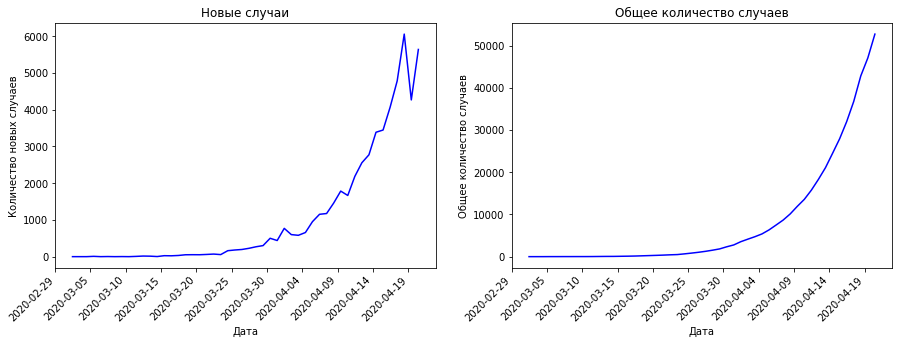

In [103]:
fig, axis = plt.subplots(figsize=(15,5), nrows=1, ncols=2)
fig.autofmt_xdate(rotation=45)

axis[0].plot(train["date"], train["new_cases"], color="blue")
axis[0].set_xlabel("Дата")
axis[0].set_ylabel("Количество новых случаев")
axis[0].set_title("Новые случаи")
start, end = axis[0].get_xlim()
axis[0].xaxis.set_ticks(np.arange(start, end, 5))


axis[1].plot(train["date"], train["total_cases"], color="blue")
axis[1].set_xlabel("Дата")
axis[1].set_ylabel("Общее количество cлучаев")
axis[1].set_title("Общее количество случаев")
start, end = axis[1].get_xlim()
axis[1].xaxis.set_ticks(np.arange(start, end, 5))

plt.show()

Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.


In [104]:
test_size = 20

model = LinearRegression()

x_train, y_train = train["day_number"].values.reshape(-1, 1), np.log(train["total_cases"])
x_test, y_test = test["day_number"][:test_size].values.reshape(-1, 1), test["total_cases"][:test_size]

model.fit(x_train, y_train)
preds = np.exp(model.predict(x_test))

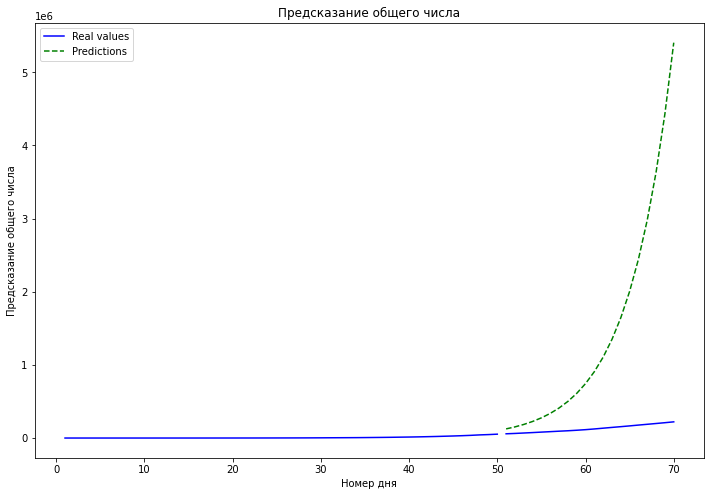

In [105]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(train["day_number"], train["total_cases"], label="Real values", color="blue")
ax.plot(test["day_number"][:test_size], test["total_cases"][:test_size], color="blue")
ax.plot(test["day_number"][:test_size], preds, label="Predictions", linestyle='--', color="green")
plt.xlabel("Номер дня")
plt.ylabel("Предсказание общего числа")
plt.title("Предсказание общего числа")
plt.legend()
plt.show()

Вывод: Экспонента растет намного быстрее, чем реальное количество заболеваний.

Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).


In [106]:
noise_var = (np.log(train["total_cases"]) - model.predict(x_train)).var()

In [107]:
model.coef_

array([0.19829091])

In [108]:
model.intercept_

1.62244623644881

In [109]:
mu0, sigma0 = np.array([0, 0]), 10 * np.array([[1, 0], [0, 1]])
X = np.hstack((np.ones((len(x_train), 1)), x_train))

In [110]:
def bayesian_update(mu0, sigma0, x, y, noise_var):
    sigma = np.linalg.inv(np.linalg.inv(sigma0) + (1 / noise_var) * np.transpose(x) @ x)
    mu = np.matmul(sigma, np.matmul(np.linalg.inv(sigma0), np.transpose(mu0)) + (1 / noise_var) * np.matmul(np.transpose(x), y))
    return mu, sigma

In [111]:
mu, sigma = bayesian_update(mu0, sigma0, X, y_train, noise_var)

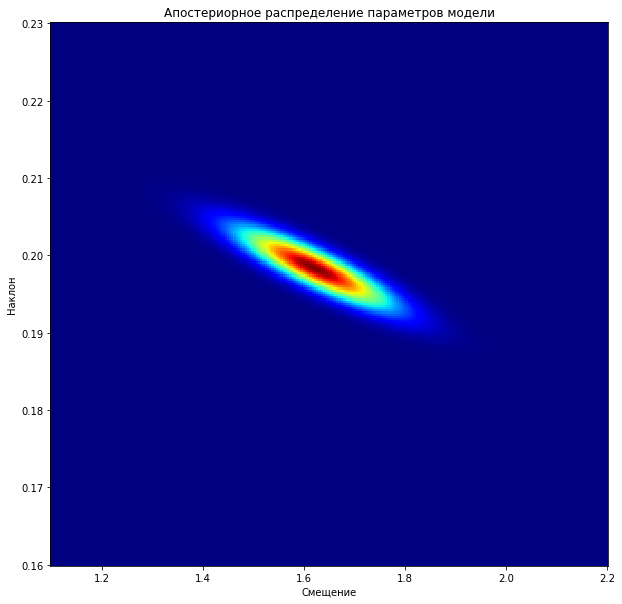

In [115]:
N = 250
X = np.linspace(1.1, 2.2, N)
Y = np.linspace(0.16, 0.23, N)
X, Y = np.meshgrid(X, Y)

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y
Z = multivariate_normal.pdf(pos, mean=mu, cov=sigma)
plt.figure(figsize=(10, 10))
plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)
plt.title('Апостериорное распределение параметров модели')
plt.xlabel('Смещение')
plt.ylabel('Наклон')
plt.show()

Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).


In [116]:
weights = np.random.multivariate_normal(mu, sigma, 100)

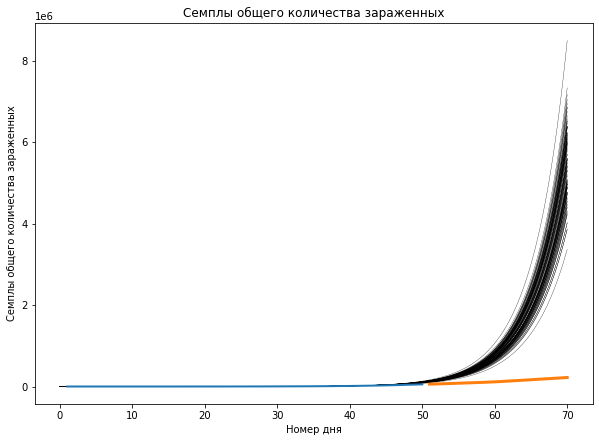

In [117]:
xs = np.linspace(0, train_size + test_size, N)
plt.figure(figsize=(10, 7))
for w in weights:
    plt.plot(xs, np.exp(w[0] + w[1] * xs), 'k-', lw=.3)
plt.plot(train["day_number"], train["total_cases"], label="Train values",  linewidth=2)
plt.plot(test["day_number"][:test_size], test["total_cases"][:test_size], label="Test values",  linewidth=3)
plt.xlabel("Номер дня")
plt.ylabel("Семплы общего количества зараженных")
plt.title("Семплы общего количества зараженных")
plt.show()

In [118]:
def get_prediction(date, model=model, start_date=start_date):
    return int(np.exp(model.predict(np.array((pd.to_datetime(date) - start_date).days + 1).reshape(-1, 1))))

In [119]:
print("Количество случаев коронавируса в России к 1 мая 2020 года - ", get_prediction("2020-05-01"))
print("Количество случаев коронавируса в России к 1 июня 2020 года - ", get_prediction("2020-06-01"))
print("Количество случаев коронавируса в России к 1 сентября 2020 года - ", get_prediction("2020-09-01"))

Количество случаев коронавируса в России к 1 мая 2020 года -  744077
Количество случаев коронавируса в России к 1 июня 2020 года -  347723874
Количество случаев коронавируса в России к 1 сентября 2020 года -  29104907396230516


In [120]:
def get_predict_samples(x, n_samples, weights):
    x_with_bias = np.hstack((np.ones((len(x), 1)), x))
    results = []
    for w in weights:
        results.append(np.exp(np.matmul(x_with_bias, w)))
    return results

In [121]:
def plot_predictive_dist(x, n_samples, weights):
    preds = get_predict_samples(x, n_samples, weights)
    plt.figure(figsize=(10, 7))
    sns.distplot(np.array(preds).mean(axis=1)).set_title("Предсказательное распределение")
    

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


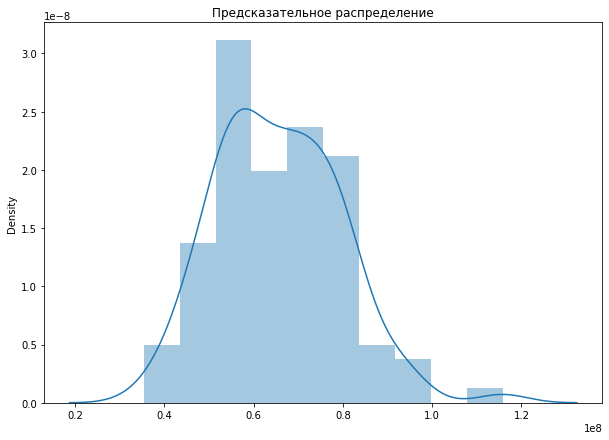

In [122]:
start = test_size + train_size
x = np.arange(start, start + 20, 1).reshape(-1, 1)
plot_predictive_dist(x, 1000, weights)

#### Задание 3

Предсказания экспоненциальной модели наверняка получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана:

Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту), а в экспоненте под интегралом может быть произвольная квадратичная функция от t.


a. Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.


Будем моделировать количество новых случаев плотностью нормального распределения. Предсказывать будем логарифм таргета. Чтобы посчитать кол-во общих случаев надо просто суммировать по количеству новых случаев.

b. Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.


In [123]:
new_x_train, new_y_train = np.array([x_train, (x_train) ** 2]).T[0], np.log(train["new_cases"])
new_x_test, new_y_test = np.array([x_test, (x_test) ** 2]).T[0], test["new_cases"][:test_size]

In [124]:
sigmoid_model = LinearRegression()
sigmoid_model.fit(new_x_train, new_y_train)
preds = np.exp(sigmoid_model.predict(new_x_test))
preds_sum = np.cumsum(preds)

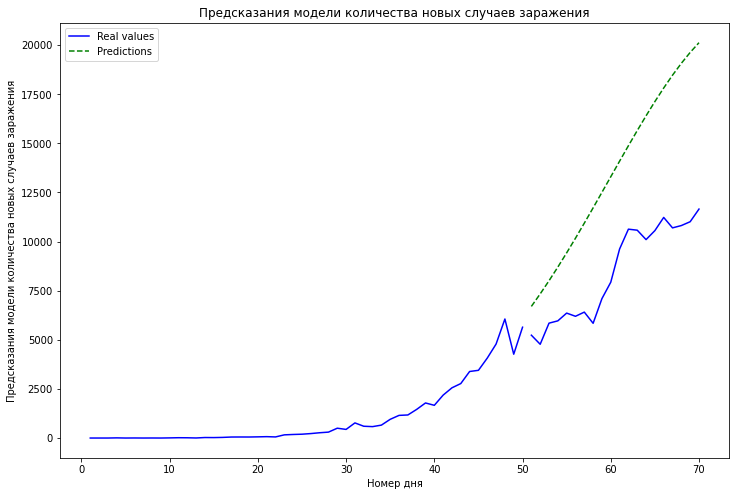

In [125]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(train["day_number"], train["new_cases"], label="Real values", color="blue")
ax.plot(test["day_number"][:test_size], test["new_cases"][:test_size], color="blue")
ax.plot(test["day_number"][:test_size], preds, label="Predictions", linestyle='--', color="green")
plt.xlabel("Номер дня")
plt.ylabel("Предсказания модели количества новых случаев заражения")
plt.title("Предсказания модели количества новых случаев заражения")
plt.legend()
plt.show()

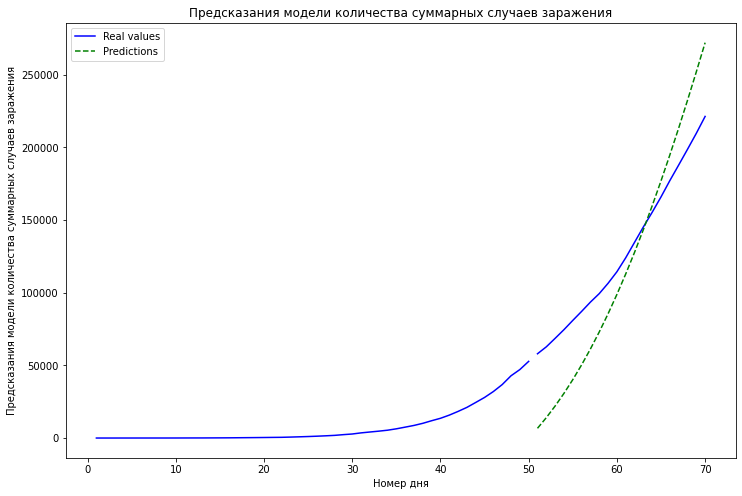

In [126]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(train["day_number"], train["total_cases"], label="Real values", color="blue")
ax.plot(test["day_number"][:test_size], test["total_cases"][:test_size], color="blue")
ax.plot(test["day_number"][:test_size], preds_sum, label="Predictions", linestyle='--', color="green")
plt.xlabel("Номер дня")
plt.ylabel("Предсказания модели количества суммарных случаев заражения")
plt.title("Предсказания модели количества суммарных случаев заражения")
plt.legend()
plt.show()

In [127]:
noise_var = (np.log(train["new_cases"]) - sigmoid_model.predict(new_x_train)).var()

In [128]:
mu0, sigma0 = np.array([0, 0, 0]), 200 * np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
x = np.hstack((np.ones((len(new_x_train), 1)), new_x_train))

In [129]:
mu, sigma = bayesian_update(mu0, sigma0, x, new_y_train, noise_var)

In [130]:
print("Параметры аостериорного распределения параметров модели:")
print("mu = ", mu)
print("sigma = ", sigma)

Параметры аостериорного распределения параметров модели:
mu =  [-0.67387716  0.27926915 -0.00182957]
sigma =  [[ 4.76516013e-02 -3.77376598e-03  6.22733518e-05]
 [-3.77376598e-03  3.89920593e-04 -7.18592546e-06]
 [ 6.22733518e-05 -7.18592546e-06  1.40904166e-07]]


c. Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?

In [131]:
weights = np.random.multivariate_normal(mu, sigma, 100)

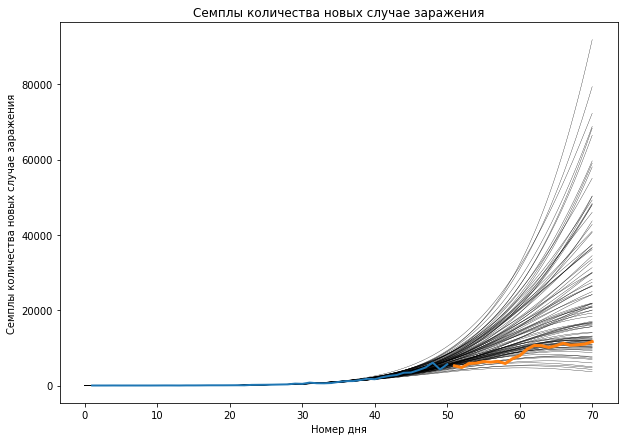

In [132]:
xs = np.linspace(0, train_size + test_size, N)
plt.figure(figsize=(10, 7))
for w in weights:
    plt.plot(xs, np.exp(w[0] + w[1] * xs + w[2] * xs * xs), 'k-', lw=.3)
plt.plot(train["day_number"], train["new_cases"], label="Train values",  linewidth=2)
plt.plot(test["day_number"][:test_size], test["new_cases"][:test_size], label="Test values",  linewidth=3)
plt.xlabel("Номер дня")
plt.ylabel("Семплы количества новых случае заражения")
plt.title("Семплы количества новых случае заражения")
plt.show()

In [36]:
def plot_predictions(preds_count, model=sigmoid_model):
    x = np.arange(1, preds_count, 1)
    x_for_preds = np.array([x, x ** 2]).T
    preds = np.exp(model.predict(x_for_preds))
    plt.figure(figsize=(10, 7))
    plt.xlabel("Номер дня")
    plt.ylabel("Количество новых случае заражения")
    plt.title("Предсказания количества новых случаев заражений")
    plt.plot(preds)
    plt.show()

Построим графики предсказаний для количества новых случаев заражений.

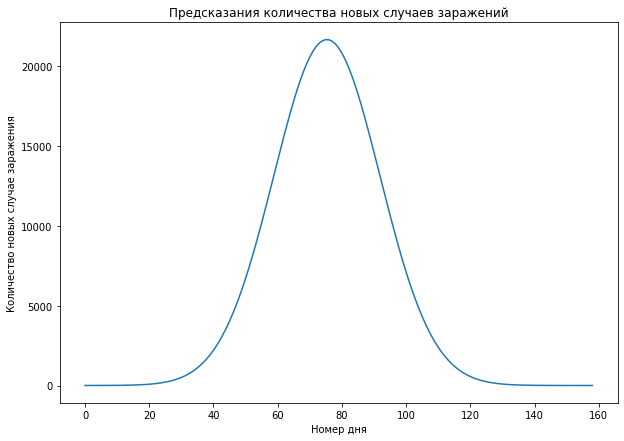

In [135]:
n_days = 160
x = np.arange(1, n_days, 1)
x_for_preds = np.array([x, x ** 2]).T
preds = np.exp(sigmoid_model.predict(x_for_preds))
plt.figure(figsize=(10, 7))
plt.xlabel("Номер дня")
plt.ylabel("Количество новых случае заражения")
plt.title("Предсказания количества новых случаев заражений")
plt.plot(preds)
plt.show()

In [136]:
x_for_n_days = np.arange(1, n_days, 1).reshape(-1, 1)
x = np.array([x_for_n_days, (x_for_n_days) ** 2]).T[0]
preds = get_predict_samples(x, 150, weights)

In [137]:
all_infected_cases_samples = np.array(preds).cumsum(axis=1)[:, -1]

In [138]:
print("Прогноз числа случаев коронавируса в пессимистичном сценарии - ", int(np.percentile(all_infected_cases_samples, 90)))
print("прогноз числа случаев коронавируса в оптимистичном сценарии - ", int(np.percentile(all_infected_cases_samples, 10)))

Прогноз числа случаев коронавируса в пессимистичном сценарии -  6104429
прогноз числа случаев коронавируса в оптимистичном сценарии -  351913


/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


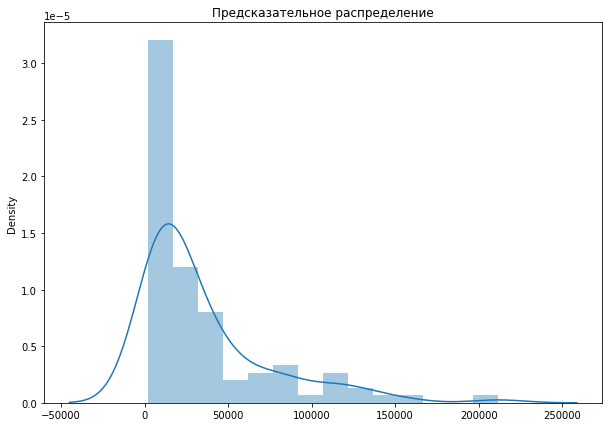

In [139]:
x = np.arange(start, start + 20, 1)
x_for_preds = np.array([x, x ** 2]).T
plot_predictive_dist(x_for_preds, 1000, weights)